In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from tqdm import tqdm

%load_ext autoreload
%autoreload 2


In [5]:
import sys
sys.path.append("../")

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

We will use the Two Moons distribution as our target density.

(-2.0, 2.0)

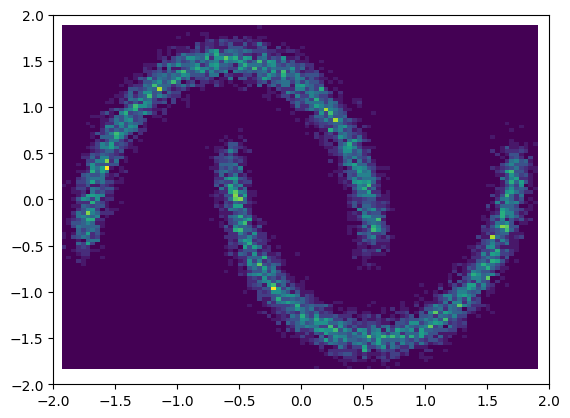

In [6]:

n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

We will allow for a rotation of the density by a specified angle, which will act as our conditioning context.

In [14]:
def rotate_points(points, angle):
    """Rotate points by angle around origin
    """
    angle = jnp.deg2rad(angle)
    rot_matrix = jnp.array([[jnp.cos(angle), -jnp.sin(angle)], [jnp.sin(angle), jnp.cos(angle)]])
    return jnp.dot(points, rot_matrix)

(-2.0, 2.0)

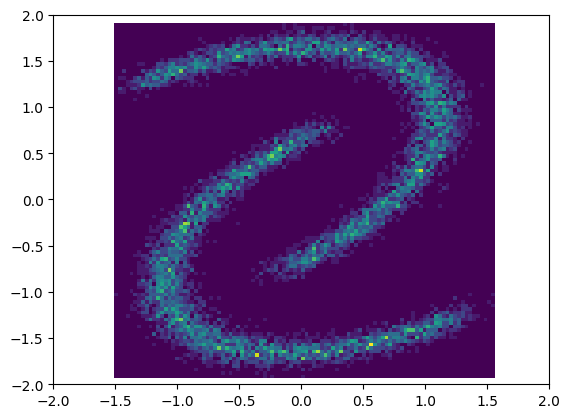

In [15]:
# Rotate points by 60 degrees
x_rot = jax.vmap(rotate_points)(x[None, :], jnp.array([60.]))[0]
plt.hist2d(x_rot[:, 0], x_rot[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

Instantiate the flow, and train on randomly-sampled points, each pair being randomly rotated by a given angle.

In [32]:
n_dim = 2
n_context = 1

model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=12, activation="tanh", use_random_permutations=False)
# model = NeuralSplineFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=8, activation="relu", n_bins=4)

key = jax.random.PRNGKey(42)
x_test = jax.random.uniform(key=key, shape=(64, n_dim))
context = jax.random.uniform(key=key, shape=(64, n_context))
params = model.init(key, x_test, context)

# model.apply(params, x_test, jnp.ones((x_test.shape[0], n_context)));

In [33]:
optimizer = optax.adam(learning_rate=2e-4)
opt_state = optimizer.init(params)

def loss_fn(params, x, context):
  loss = -jnp.mean(model.apply(params, x, context))
  return loss

@jax.jit
def update(params, opt_state, batch):
  x, context = batch
  grads = jax.grad(loss_fn)(params, x, context)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state


In [34]:
batch_size = 128
n_steps = 20_000

for step in tqdm(range(n_steps)):

    # Sample a batch
    x_batch = x[np.random.choice(np.arange(len(x)), size=batch_size, replace=False)]

    # Rotate each pair of points by a random angle from 0 to pi
    rot = np.random.uniform(low=0., high=np.pi, size=batch_size)
    x_batch = jax.vmap(rotate_points)(x_batch, np.rad2deg(rot))

    # Conditioning context based on rotation angle
    context = jnp.array(rot)[:, None]
    
    # Update
    batch = (x_batch , context)
    params, opt_state = update(params, opt_state, batch)


100%|██████████| 20000/20000 [03:57<00:00, 84.29it/s]


In [35]:
def sample_from_flow(rot=45., n_samples=10_000, key=jax.random.PRNGKey(42)):
    """Helper function to sample from the flow model
    """
    def sample_fn(model):
        x_samples = model.sample(num_samples=n_samples, rng=key, context=np.deg2rad(rot) * jnp.ones((n_samples, 1)))
        return x_samples

    x_samples = nn.apply(sample_fn, model)(params)
    return x_samples

100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


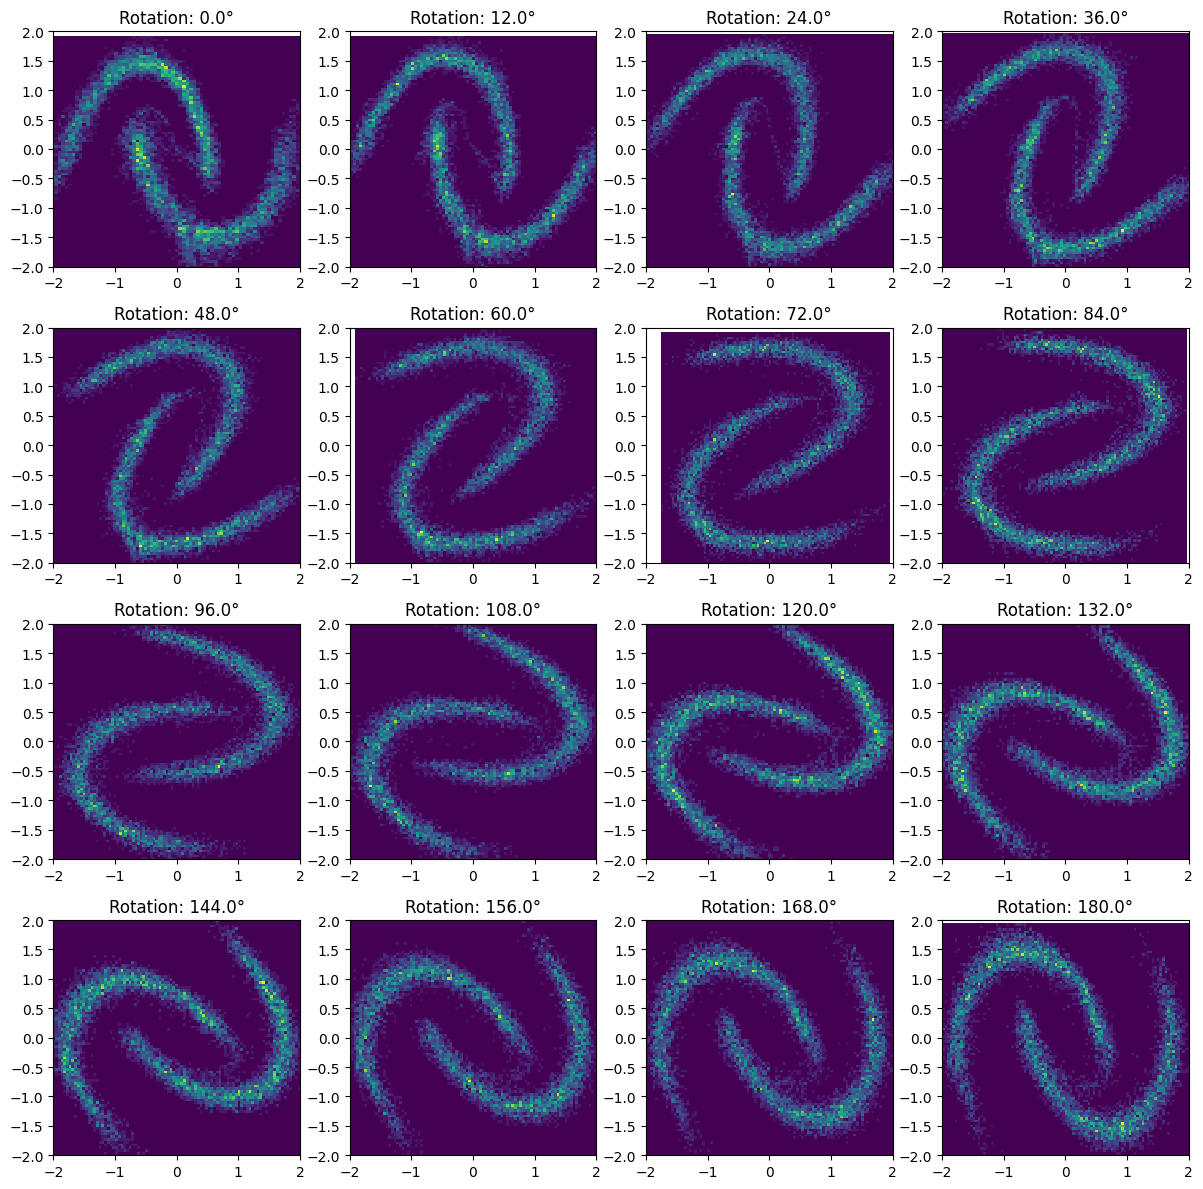

In [36]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

rot_list = np.linspace(0., 180., 16)

for i in tqdm(range(16)):

    x_samples = sample_from_flow(rot=rot_list[i])
    ax = fig.add_subplot(gs[i])

    ax.hist2d(x_samples[:, 0], x_samples[:, 1], bins=100)
    ax.set_title("Rotation: {}°".format(rot_list[i]))
    ax.set_xlim(-2 ,2)
    ax.set_ylim(-2, 2)

plt.tight_layout()